# LangGraph Quickstart

In [42]:
import os
import sys
import json
import datetime

from typing import Annotated
from typing_extensions import TypedDict

from IPython.display import Image, display
import networkx as nx

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import OpenAI, ChatOpenAI
from langchain_community.tools import TavilySearchResults
from langchain.chat_models import init_chat_model
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt

from langchain_core.messages import ToolMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig, chain
from langchain_core.tools import InjectedToolCallId, tool

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from lib.utils import set_chatgpt_env, set_langsmith_env, set_tavily_env

In [4]:
set_chatgpt_env()
set_langsmith_env()
set_tavily_env()

## Basic Chatbot

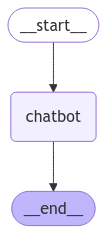

In [6]:
llm = ChatOpenAI(model='gpt-4-turbo')

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [7]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    stream_graph_updates(user_input)

Goodbye!


## Tavily Search

In [9]:
search_tool = TavilySearchResults(
    max_results=5,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
    # include_domains=[...],
    # exclude_domains=[...],
    # name="...",            # overwrite default tool name
    # description="...",     # overwrite default tool description
    # args_schema=...,       # overwrite default args_schema: BaseModel
)

In [10]:
search_tool.invoke({"query": "What happened at the last wimbledon"})

[{'url': 'https://www.nbcnews.com/news/sports/andy-murray-wimbledon-tennis-singles-draw-rcna159912',
  'content': "NBC News Now LONDON — Andy Murray, one of the last decade's most successful male tennis players, has pulled out of the singles tournament at what is almost certain to be his last Wimbledon, his team confirmed Tuesday. Murray, 37, who has won the Wimbledon singles title twice and the U.S Open once, has been battling to be fit to play at the All England Club for weeks. “Unfortunately, despite working incredibly hard on his recovery since his operation just over a week ago, Andy has taken the very difficult decision not to play the singles this year,” his team said in a statement reported by Sky News. The news caps a glittering career on the ATP singles tour, which placed Murray at No. 1 in the world for 41 weeks."},
 {'url': 'https://www.atptour.com/en/news/murray-wimbledon-2024-reflections',
  'content': "Andy Murray's Wimbledon farewell: The man 'who left no stone unturned

In [11]:
# This is usually generated by a model, but we'll create a tool call directly for demo purposes.
model_generated_tool_call = {
    "args": {"query": "euro 2024 host nation"},
    "id": "1",
    "name": "tavily",
    "type": "tool_call",
}
tool_msg = search_tool.invoke(model_generated_tool_call)

# The content is a JSON string of results
print(tool_msg.content[:100])

[{"url": "https://www.sportingnews.com/uk/football/news/list-euros-host-nations-uefa-european-champi


In [12]:
# The artifact is a dict with richer, raw results
{k: type(v) for k, v in tool_msg.artifact.items()}

{'query': str,
 'follow_up_questions': NoneType,
 'answer': str,
 'images': list,
 'results': list,
 'response_time': float}

In [13]:
print(json.dumps({k: str(v)[:200] for k, v in tool_msg.artifact.items()}, indent=2))

{
  "query": "euro 2024 host nation",
  "follow_up_questions": "None",
  "answer": "Germany is the host nation for Euro 2024, with matches taking place from June 14 to July 14 across ten cities: Berlin, Cologne, Munich, Frankfurt, Hamburg, Dortmund, Leipzig, Gelsenkirchen, Stuttgart,",
  "images": "['https://www.dfb.de/fileadmin/_processed_/202110/csm_248219-EURO2024_HC_Gelsenkirchen_FC_CMYK_266df023cc.png', 'https://img.planetafobal.com/2021/10/sedes-uefa-euro-2024-alemania-fg-1024x926.jpg', 'h",
  "results": "[{'title': 'Complete list of Euros host nations: Countries to have held UEFA ...', 'url': 'https://www.sportingnews.com/uk/football/news/list-euros-host-nations-uefa-european-championship-countries/85",
  "response_time": "3.76"
}


### Chaining

In [14]:
llm = init_chat_model("gpt-4o-mini", model_provider="openai")

In [15]:
today = datetime.datetime.today().strftime("%D")
prompt = ChatPromptTemplate(
    [
        ("system", f"You are a helpful assistant. The date today is {today}."),
        ("human", "{user_input}"),
        ("placeholder", "{messages}"),
    ]
)

In [16]:
# specifying tool_choice will force the model to call this tool.
llm_with_tools = llm.bind_tools([search_tool])
llm_chain = prompt | llm_with_tools

@chain
def tool_chain(user_input: str, config: RunnableConfig):
    input_ = {"user_input": user_input}
    ai_msg = llm_chain.invoke(input_, config=config)
    tool_msgs = search_tool.batch(ai_msg.tool_calls, config=config)
    return llm_chain.invoke({**input_, "messages": [ai_msg, *tool_msgs]}, config=config)


tool_chain.invoke("who won the last womens singles wimbledon").content

"The most recent winner of the women's singles at Wimbledon is Barbora Krejcikova, who claimed the title in 2024 by defeating Jasmine Paolini with a score of 6-2, 2-6, 6-4. This victory marked Krejcikova's second Grand Slam singles title."

### LangGraph with Search Tool

In [17]:
tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48',
  'content': "Beginner’s Guide to LangGraph: Understanding State, Nodes, and Edges — Part 1 | by Kamal Dhungana | Medium Beginner’s Guide to LangGraph: Understanding State, Nodes, and Edges — Part 1 LangGraph — State, Node and Edge Explained Mainly, we will focus on various components of LangGraph: State, Node, and Edges, and how to build a complete graph from these components. Once we understand these components, we will be able to build relatively complex LangGraph-based agents. Each node represents a specific function or operation that processes the current state. Nodes can perform computations, modify the state, or generate outputs based on the input they receive. Follow 1.2K Followers Data scientist with a passion for AI, Regularly blogging about LLM and OpenAI's innovations,Sharing insights for AI community growth Follow"},
 {'url': 'https://blog.langchain

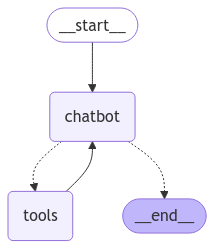

In [18]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}
    
def route_tools(state: State):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


graph_builder = StateGraph(State)
llm = init_chat_model("gpt-4o-mini", model_provider="openai")
llm_with_tools = llm.bind_tools(tools)

graph_builder.add_node("chatbot", chatbot)

tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)
            
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: [{"url": "https://www.espn.com/nfl/game/_/gameId/401438030/chiefs-eagles", "content": "Chiefs 38-35 Eagles (Feb 12, 2023) Final Score - ESPN ESPN Mahomes 21/27, 182 YDS, 3 TD PHI ### J. Pacheco 15 CAR, 76 YDS, 1 TD PHI ### J. Game Information Super Bowl magic: Mahomes, Chiefs beat Eagles 38-35 --------------------------------------------------- \u2014 Patrick Mahomes was magical when the Kansas City Chiefs desperately needed him to pull off another Super Bowl comeback. 1st Quarter Travis Kelce 18 Yd pass from Patrick Mahomes (Harrison Butker Kick) A.J. Brown 45 Yd pass from Jalen Hurts (Jake Elliott Kick) Kadarius Toney 5 Yd pass from Patrick Mahomes (Harrison Butker Kick) Skyy Moore 4 Yd pass from Patrick Mahomes (Harrison Butker Kick) Work for ESPN ESPN BET is available in states where PENN is licensed to offer sports wagering."}, {"url": "https://www.marca.com/en/nfl/winners.html", "content": "NFL En/nfl NFL | 2024 | Kansas City Chiefs | San Francisco 49ers | 

## Adding Memory tp Chatbot

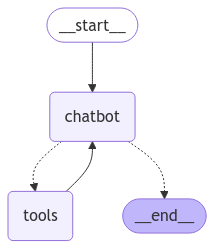

In [27]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder = StateGraph(State)
llm = init_chat_model("gpt-4o-mini", model_provider="openai")

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

### Verify that Chat is saved

In [28]:
config = {"configurable": {"thread_id": "1"}}
user_input = "Hi there! My name is Will."

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hi Will! How can I assist you today?


In [29]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name is Will! How can I help you today?


### Create a second thread

This verifies that memory is accessed using thread ID.

In [30]:
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I don’t have the capability to remember personal information like names from previous interactions. How can I assist you today?


In [31]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='6f8f67fa-9d63-4b88-900a-650735dbae6e'), AIMessage(content='Hi Will! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 87, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_13eed4fce1', 'finish_reason': 'stop', 'logprobs': None}, id='run-a508c47c-6509-49b0-a8d0-fa6421890c95-0', usage_metadata={'input_tokens': 87, 'output_tokens': 12, 'total_tokens': 99, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='Remember my name?', additional_kwargs={}, r

## Human-in-the-loop

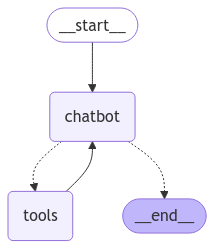

In [36]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm = init_chat_model("gpt-4o-mini", model_provider="openai")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

### Request Human Assistance

In [37]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_MUdfKACwUTmj1eyfMVCFJkQ3)
 Call ID: call_MUdfKACwUTmj1eyfMVCFJkQ3
  Args:
    query: expert guidance for building an AI agent


In [38]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

### Human Responds

In [39]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_MUdfKACwUTmj1eyfMVCFJkQ3)
 Call ID: call_MUdfKACwUTmj1eyfMVCFJkQ3
  Args:
    query: expert guidance for building an AI agent
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

For building an AI agent, it's recommended to check out **LangGraph**. It is considered more reliable and extensible compared to simple autonomous agents. If you need more specific guidance or have further questions, just let me know!


## Customizing State

Add properties to the state object.

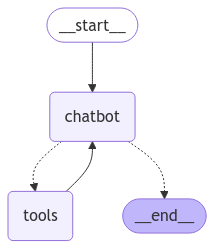

In [46]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

graph_builder = StateGraph(State)


@tool
# Note that because we are generating a ToolMessage for a state update, we
# generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolCallId to signal that this argument should not
# be revealed to the model in the tool's schema.
def human_assistance(name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm = init_chat_model("gpt-4o-mini", model_provider="openai")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [47]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_MwCqdgUBM4V0KM5ASFK9OLrj)
 Call ID: call_MwCqdgUBM4V0KM5ASFK9OLrj
  Args:
    query: LangGraph release date
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://pypi.org/project/langgraph/", "content": "LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. The simplest way to create a tool-calling agent in LangGraph is to use create_react_agent: # Define the tools for the agent to use # Define the tools for the agent to use # This means that after `tools` is called, `agent` node is called next. workflow.add_edge(\"t

In [48]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_ku8AjlseYs0JsFDlbLTBsuy1)
 Call ID: call_ku8AjlseYs0JsFDlbLTBsuy1
  Args:
    name: LangGraph
    birthday: February 6, 2025
================================= Tool Message =================================
Name: human_assistance

Made a correction: {'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}
================================== Ai Message ==================================

LangGraph was actually released on January 17, 2024.


In [49]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}

## Manually Updating State

In [50]:
graph.update_state(config, {"name": "LangGraph (library)"})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efec9d3-e36a-6844-8006-c20d454dc92d'}}

In [51]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph (library)', 'birthday': 'Jan 17, 2024'}

## Time Travel

Time Travel allows users to branch off past states in the dialog interaction with an agent.

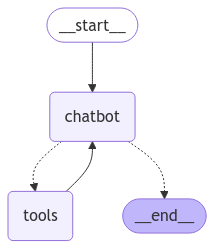

In [52]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder = StateGraph(State)
llm = init_chat_model("gpt-4o-mini", model_provider="openai")

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

### Create a State History

In [53]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "I'm learning LangGraph. "
                    "Could you do some research on it for me?"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_T5MFgkzmHFb6jdeAhFiAuYQE)
 Call ID: call_T5MFgkzmHFb6jdeAhFiAuYQE
  Args:
    query: LangGraph overview
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle

In [54]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Ya that's helpful. Maybe I'll "
                    "build an autonomous agent with it!"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

That sounds like a great idea! Building an autonomous agent with LangGraph can be an exciting project. You can leverage its ability to manage state and coordinate multiple LLM agents to create a system that operates independently, responds intelligently to user input, and adapts its actions based on learned experiences. 

If you're looking for specific features or functionalities to include, or if you need guidance on any aspect of building your autonomous agent, feel free to ask. Good luck with your project!


### Replay State History

Checkpoints are saved for every step of the graph.

In [58]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 3:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  6 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  0 Next:  ('__start__',)
--------------------------------------------------------------------------------


In [59]:
print(to_replay.next)
print(to_replay.config)

('chatbot',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efecb83-1863-673e-8002-2eede823dbe1'}}


In [60]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interactions."}, {"url": "https://medium.com/@cplog/introduction-to-langgrap